In [1]:
import scipy.io
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.metrics import r2_score
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class NasaBatteryDatasetBuilder:
    def __init__(self, interpolation_points=1000, rated_capacity=2.0,
                 interpolation_targets={'q': True, 'i': True, 't': True},
                 mode="spline"):
        self.interpolation_points = interpolation_points
        self.rated_capacity = rated_capacity
        self.interpolation_targets = interpolation_targets
        self.v_grid = np.linspace(3.0, 4.2, interpolation_points)
        self.mode = mode

    def audit_duplicate_removal_safety(self, df, signal="voltage_raw", threshold=1e-5):
            """
            Audit each cycle to determine whether removing duplicates significantly affects dY/dt.
            Returns a DataFrame with the 'safe_to_remove' flag per cycle.
            """
            import numpy as np
            import pandas as pd

            results = []

            for _, row in df.iterrows():
                cell_id = row["cell_id"]
                cycle_index = row["cycle_index"]
                T = np.array(row["time_raw"])
                Y = np.array(row[signal])

                # Skip mismatched or malformed rows
                if len(T) != len(Y) or len(T) < 3:
                    results.append((cell_id, cycle_index, np.nan, np.nan, np.nan, False))
                    continue

                # Remove duplicates
                mask = np.diff(T, prepend=-np.inf) > 0
                T_clean, Y_clean = T[mask], Y[mask]

                # Average duplicates
                df_avg = pd.DataFrame({'T': T, 'Y': Y}).groupby('T', as_index=False).mean()
                T_avg, Y_avg = df_avg['T'].values, df_avg['Y'].values

                # Compute derivatives
                try:
                    d_clean = np.gradient(Y_clean, T_clean)
                    d_avg = np.gradient(Y_avg, T_avg)

                    min_len = min(len(d_clean), len(d_avg))
                    diff = np.abs(d_clean[:min_len] - d_avg[:min_len])
                    mean_abs_diff = np.mean(diff)

                    # Flag: is removing duplicates safe?
                    is_safe = mean_abs_diff < threshold

                    results.append((cell_id, cycle_index, mean_abs_diff, d_clean.std(), d_avg.std(), is_safe))

                except Exception:
                    results.append((cell_id, cycle_index, np.nan, np.nan, np.nan, False))

            return pd.DataFrame(results, columns=[
                "cell_id", "cycle_index", "mean_abs_dYdt_diff", "std_dYdt_clean", "std_dYdt_avg", "safe_to_remove"
            ])

    def find_all_mat_files(self, base_folder):
        return list(Path(base_folder).rglob("*.mat"))

    def load_mat_file(self, file_path):
        mat = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)
        key = [k for k in mat.keys() if not k.startswith("__")][0]
        return mat[key].cycle

    def validate_all_against_voltage_time(self, t_v, **kwargs):
        """
        Validates that all provided time arrays are aligned with the voltage time vector (t_v).
        Parameters:
            t_v (np.ndarray): Time array for voltage
            **kwargs: Named time arrays to check (e.g. t_q=t_q, t_T=t_T, ...)
        Returns:
            bool: True if all are aligned, False otherwise
        """
        all_good = True
        for name, t_arr in kwargs.items():
            if len(t_arr) != len(t_v):
                print(f"[Mismatch] {name}: len={len(t_arr)} vs voltage len={len(t_v)}")
                all_good = False
                continue
            diff = np.abs(t_arr - t_v)
            if np.any(diff > 1e-3):
                print(f"[Mismatch] {name}: max time diff = {np.max(diff):.6f}s")
                all_good = False
        return all_good

    def compute_derivative_stats(self, Y, T):
        if len(Y) != len(T) or len(Y) < 2:
            return {"min": np.nan, "max": np.nan, "mean": np.nan, "std": np.nan}
        
        # Remove duplicates
        T = np.array(T, dtype=float)
        Y = np.array(Y)
        valid = np.diff(T, prepend=-np.inf) > 0
        T, Y = T[valid], Y[valid]

        if len(T) < 2:
            return {"min": np.nan, "max": np.nan, "mean": np.nan, "std": np.nan}

        dYdt = np.gradient(Y, T)
        return {
            "min": np.min(dYdt),
            "max": np.max(dYdt),
            "mean": np.mean(dYdt),
            "std": np.std(dYdt)
        }

    def extract_discharge_cycles(self, cycle_data):
        return [i for i, c in enumerate(cycle_data) if getattr(c, "type", None) == "discharge"]

    def extract_cycle_data(self, cycle_data, index):
        cycle = cycle_data[index].data
        V = np.atleast_1d(cycle.Voltage_measured).flatten()
        I = -np.atleast_1d(cycle.Current_measured).flatten() # flip polarity
        T = np.atleast_1d(cycle.Time).flatten()
        Temp = np.atleast_1d(cycle.Temperature_measured).flatten()
        capacity_raw = np.atleast_1d(getattr(cycle, "Capacity", [])).flatten()
        if capacity_raw.size == 0:
            raise ValueError("Empty capacity")
        return V, I, T, Temp, float(capacity_raw[0])

    def compute_charge(self, T, I):
        if len(T) < 2 or len(T) != len(I):
            return None
        order = np.argsort(T) # align with T
        T_sorted = T[order]
        I_sorted = I[order]
        dt = np.diff(T_sorted, append=T_sorted[-1])
        Q = np.cumsum(I_sorted * dt) / 3600
        return Q, order

    def sample_signal(self, V, Y):
        idx = (V >= 3.0) & (V <= 4.2)
        V, Y = V[idx], Y[idx]
        if len(V) < 2:
            return None
        order = np.argsort(V)
        V, Y = V[order], Y[order]
        return np.interp(self.v_grid, V, Y)

    def interpolate_signals(self, V, I, T, Temp):
        Q, t_order = self.compute_charge(T, I)
        if Q is None:
            return None

        # Time alignment
        V_aligned = V[t_order]
        Q_aligned = Q[t_order]
        I_aligned = I[t_order]
        Temp_aligned = Temp[t_order]

        # Voltage mask
        mask = (V_aligned >= 3.0) & (V_aligned <= 4.2)
        if np.count_nonzero(mask) < 10:
            return None

        # Apply mask and sort by voltage
        V_masked = V_aligned[mask]
        sort_idx = np.argsort(V_masked)

        V_final = V_masked[sort_idx]
        Q_final = Q_aligned[mask][sort_idx]
        I_final = I_aligned[mask][sort_idx]
        Temp_final = Temp_aligned[mask][sort_idx]

        result = {}

        if self.mode == 'sample':
            if self.interpolation_targets.get('q'): result['q'] = self.sample_signal(V_final, Q_final)
            if self.interpolation_targets.get('i'): result['i'] = self.sample_signal(V_final, I_final)
            if self.interpolation_targets.get('t'): result['t'] = self.sample_signal(V_final, Temp_final)
        elif self.mode == 'spline':
            def safe_spline(x, y, s=1e-2):
                if np.allclose(y, y[0], rtol=1e-4):
                    return np.full_like(self.v_grid, y[0])
                for _ in range(5):
                    tck = interpolate.splrep(x, y, s=s)
                    if not np.isnan(tck[1]).any():
                        return interpolate.splev(self.v_grid, tck)
                    s *= 10
                return np.full_like(self.v_grid, np.nan)

            if self.interpolation_targets.get('q'): result['q'] = safe_spline(V_final, Q_final)
            if self.interpolation_targets.get('i'): result['i'] = safe_spline(V_final, I_final)
            if self.interpolation_targets.get('t'): result['t'] = safe_spline(V_final, Temp_final)
        else:
            raise ValueError("Unknown interpolation mode. Use 'spline' or 'sample'.")

        if any(val is None or np.isnan(val).all() for val in result.values()):
            print("Interpolation failed")
            return None

        result['Q'] = Q  # full aligned charge
        return result

    def process_all_files(self, base_folder):
        all_files = self.find_all_mat_files(base_folder)
        all_rows = []
        for file_path in all_files:
            cell_id = file_path.stem
            print(f"Processing {cell_id}...")
            try:
                cycle_data = self.load_mat_file(file_path)
                discharge_indices = self.extract_discharge_cycles(cycle_data)
                for idx in discharge_indices:
                    V, I, T, Temp, C = self.extract_cycle_data(cycle_data, idx)

                    # Check alignment of I, Temp, and V with T
                    if not self.validate_all_against_voltage_time(
                        t_v=T,
                        t_I=T,
                        t_Temp=T,
                        t_V=T
                    ):
                        print(f"Signal misalignment in {cell_id} cycle {idx}, skipping.")
                        continue

                    soh = C / self.rated_capacity
                    idx_valid = (V >= 3.0) & (V <= 4.2)
                    V, I, T, Temp = V[idx_valid], I[idx_valid], T[idx_valid], Temp[idx_valid]
                    if len(V) < 5:
                        continue
                    interp = self.interpolate_signals(V, I, T, Temp)
                    if interp is None:
                        continue
                    dqdt = self.compute_derivative_stats(interp["Q"], T)
                    dvdt = self.compute_derivative_stats(V, T)
                    didt = self.compute_derivative_stats(I, T)

                    row = {
                        "cell_id": cell_id,
                        "rated_capacity": self.rated_capacity,
                        "cycle_index": idx,
                        "capacity": C,
                        "soh": soh,
                        "voltage_raw": V,
                        "current_raw": I,
                        "charge_raw": interp["Q"],
                        "temperature_raw": Temp,
                        "time_raw": T,
                        "dqdt_min": dqdt["min"], "dqdt_max": dqdt["max"],
                        "dqdt_mean": dqdt["mean"], "dqdt_std": dqdt["std"],
                        "dvdt_min": dvdt["min"], "dvdt_max": dvdt["max"],
                        "dvdt_mean": dvdt["mean"], "dvdt_std": dvdt["std"],
                        "didt_min": didt["min"], "didt_max": didt["max"],
                        "didt_mean": didt["mean"], "didt_std": didt["std"],
                        **{f"q_interp_{i}": val for i, val in enumerate(interp["q"])} ,
                        **{f"i_interp_{i}": val for i, val in enumerate(interp["i"])} ,
                        **{f"t_interp_{i}": val for i, val in enumerate(interp["t"])}
                    }
                    all_rows.append(row)
            except Exception as e:
                print(f"Failed to process {cell_id}: {e}")
        return pd.DataFrame(all_rows)

    def plot_qit_from_dataframe(self, df, cell_id, cycle_index):
        row = df[(df["cell_id"] == cell_id) & (df["cycle_index"] == cycle_index)]
        if row.empty:
            print("Entry not found.")
            return
        q_vals = row.filter(like="q_interp_").values.flatten()
        i_vals = row.filter(like="i_interp_").values.flatten()
        t_vals = row.filter(like="t_interp_").values.flatten()
        V_raw = np.array(row["voltage_raw"].values[0])
        Q_raw = np.array(row["charge_raw"].values[0])
        T_raw = np.array(row["temperature_raw"].values[0])
        I_raw = np.array(row["current_raw"].values[0])
        idx = (V_raw >= 3.0) & (V_raw <= 4.2)
        V_raw, Q_raw, T_raw, I_raw = V_raw[idx], Q_raw[idx], T_raw[idx], I_raw[idx]
        order = np.argsort(V_raw)
        V_raw, Q_raw, T_raw, I_raw = V_raw[order], Q_raw[order], T_raw[order], I_raw[order]
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
        axs[0].plot(V_raw, Q_raw, label="Raw Q", linestyle="-")
        axs[0].plot(self.v_grid, q_vals, label="Interpolated Q", linestyle="--")
        axs[0].set_title("Q vs V")
        axs[0].set_ylabel("Charge (Ah)")
        axs[0].legend()
        axs[0].grid(True)
        axs[1].plot(V_raw, I_raw, label="Raw I", linestyle="-")
        axs[1].plot(self.v_grid, i_vals, label="Interpolated I", linestyle="--")
        axs[1].set_title("I vs V")
        axs[1].set_ylabel("Current (A)")
        axs[1].legend()
        axs[1].grid(True)
        axs[2].plot(V_raw, T_raw, label="Raw T", linestyle="-")
        axs[2].plot(self.v_grid, t_vals, label="Interpolated T", linestyle="--")
        axs[2].set_title("T vs V")
        axs[2].set_ylabel("Temperature (°C)")
        axs[2].legend()
        axs[2].grid(True)
        for ax in axs:
            ax.set_xlabel("Voltage (V)")
        fig.suptitle(f"Interpolation Plots for {cell_id} — Cycle Index {cycle_index}")
        plt.tight_layout()
        plt.show()

    def plot_multiple_cycles(self, df, cell_id, cycle_idx, signal='q'):
        plt.figure(figsize=(8, 5))
        for cycle_index in cycle_idx:
            row = df[(df['cell_id'] == cell_id) & (df['cycle_index'] == cycle_index)]
            if row.empty:
                print(f"Row not found for {cell_id} Cycle {cycle_index}")
                continue
            y_vals = row[[f'{signal}_interp_{i}' for i in range(self.interpolation_points)]].values.flatten()
            plt.plot(self.v_grid, y_vals, label=f'Cycle {cycle_index}')
        plt.title(f'{signal.upper()} vs Voltage for {cell_id}')
        plt.xlabel('Voltage (V)')
        plt.ylabel(signal.upper())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def plot_signals_and_derivatives_vs_time(self, df, cell_id, cycle_index):
        row = df[(df["cell_id"] == cell_id) & (df["cycle_index"] == cycle_index)]
        if row.empty:
            print("Entry not found.")
            return

        T = np.array(row["time_raw"].values[0])
        Q = np.array(row["charge_raw"].values[0])
        V = np.array(row["voltage_raw"].values[0])
        I = np.array(row["current_raw"].values[0])

        # Sort by time
        order = np.argsort(T)
        T, Q, V, I = T[order], Q[order], V[order], I[order]

        dQdt = np.gradient(Q, T)
        dVdt = np.gradient(V, T)
        dIdt = np.gradient(I, T)

        fig, axs = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

        # Left column: raw signals
        axs[0, 0].plot(T, Q, label="Q (Ah)")
        axs[0, 0].set_ylabel("Charge (Ah)")
        axs[0, 0].legend()
        axs[0, 0].grid(True)

        axs[1, 0].plot(T, V, label="V (V)", color="orange")
        axs[1, 0].set_ylabel("Voltage (V)")
        axs[1, 0].legend()
        axs[1, 0].grid(True)

        axs[2, 0].plot(T, I, label="I (A)", color="green")
        axs[2, 0].set_ylabel("Current (A)")
        axs[2, 0].legend()
        axs[2, 0].grid(True)

        # Right column: derivatives
        axs[0, 1].plot(T, dQdt, label="dQ/dt", color="blue")
        axs[0, 1].set_ylabel("dQ/dt (A)")
        axs[0, 1].legend()
        axs[0, 1].grid(True)

        axs[1, 1].plot(T, dVdt, label="dV/dt", color="orange")
        axs[1, 1].set_ylabel("dV/dt (V/s)")
        axs[1, 1].legend()
        axs[1, 1].grid(True)

        axs[2, 1].plot(T, dIdt, label="dI/dt", color="green")
        axs[2, 1].set_ylabel("dI/dt (A/s)")
        axs[2, 1].legend()
        axs[2, 1].grid(True)

    def plot_signals_and_derivatives_plotly(self, df, cell_id, cycle_index):
        row = df[(df["cell_id"] == cell_id) & (df["cycle_index"] == cycle_index)]
        if row.empty:
            print("Entry not found.")
            return

        T = np.array(row["time_raw"].values[0])
        Q = np.array(row["charge_raw"].values[0])
        V = np.array(row["voltage_raw"].values[0])
        I = np.array(row["current_raw"].values[0])

        order = np.argsort(T)
        T, Q, V, I = T[order], Q[order], V[order], I[order]

        dQdt = np.gradient(Q, T)
        dVdt = np.gradient(V, T)
        dIdt = np.gradient(I, T)

        fig = make_subplots(rows=3, cols=2, shared_xaxes=True,
                            subplot_titles=("Q (Ah)", "dQ/dt (A)",
                                            "V (V)", "dV/dt (V/s)",
                                            "I (A)", "dI/dt (A/s)"))

        fig.add_trace(go.Scatter(x=T, y=Q, mode='lines', name='Q (Ah)'), row=1, col=1)
        fig.add_trace(go.Scatter(x=T, y=dQdt, mode='lines', name='dQ/dt (A)', line=dict(color='blue')), row=1, col=2)

        fig.add_trace(go.Scatter(x=T, y=V, mode='lines', name='V (V)', line=dict(color='orange')), row=2, col=1)
        fig.add_trace(go.Scatter(x=T, y=dVdt, mode='lines', name='dV/dt (V/s)', line=dict(color='orange')), row=2, col=2)

        fig.add_trace(go.Scatter(x=T, y=I, mode='lines', name='I (A)', line=dict(color='green')), row=3, col=1)
        fig.add_trace(go.Scatter(x=T, y=dIdt, mode='lines', name='dI/dt (A/s)', line=dict(color='green')), row=3, col=2)

        fig.update_layout(height=900, width=1150,
                        title_text=f"Interactive Signal and Derivative Plots for {cell_id} — Cycle {cycle_index}",
                        showlegend=False)

        
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=1, col=1)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=1, col=2)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=2, col=1)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=2, col=2)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=3, col=1)
        fig.update_xaxes(title_text="Time (s)", dtick=500, row=3, col=2)

        fig.show()

In [2]:
builder = NasaBatteryDatasetBuilder(mode="sample")  # "spline" or "sample"

In [3]:
df_nasa = builder.process_all_files("../Datasets/5.+Battery+Data+Set/5. Battery Data Set")

Processing B0005...
Processing B0006...
Processing B0007...
Processing B0018...
Processing B0025...
Processing B0026...
Processing B0027...
Processing B0028...
Processing B0025...
Processing B0026...
Processing B0027...
Processing B0028...
Processing B0029...
Processing B0030...
Processing B0031...
Processing B0032...
Processing B0033...
Processing B0034...
Processing B0036...
Processing B0038...
Processing B0039...
Processing B0040...
Processing B0041...
Processing B0042...
Processing B0043...
Processing B0044...
Processing B0045...
Processing B0046...
Processing B0047...
Processing B0048...
Processing B0049...
Processing B0050...
Failed to process B0050: Empty capacity
Processing B0051...
Processing B0052...
Failed to process B0052: Empty capacity
Processing B0053...
Processing B0054...
Processing B0055...
Processing B0056...


In [4]:
df_nasa.head()

,cell_id,rated_capacity,cycle_index,capacity,soh,voltage_raw,current_raw,charge_raw,temperature_raw,time_raw,...,t_interp_990,t_interp_991,t_interp_992,t_interp_993,t_interp_994,t_interp_995,t_interp_996,t_interp_997,t_interp_998,t_interp_999
0,B0005,2.0,1,1.856487,0.928244,"[4.191491807505295, 4.190749067776103, 3.97487...","[0.004901589207462691, 0.0014780055516425076, ...","[2.284821346956428e-05, 3.061677487183637e-05,...","[24.330033885570543, 24.325993424022467, 24.38...","[0.0, 16.781, 35.702999999999996, 53.781, 71.9...",...,24.326449,24.326098,24.330034,24.330034,24.330034,24.330034,24.330034,24.330034,24.330034,24.330034
1,B0005,2.0,3,1.846327,0.923164,"[4.189773213846608, 4.188881380279099, 3.97915...","[-2.125117981080765e-05, 0.0008794712663407272...","[-9.841657494605143e-08, 4.55081055553461e-06,...","[24.697751935729325, 24.685948163596, 24.73813...","[0.0, 16.672, 35.703, 53.828, 71.891, 90.047, ...",...,24.690022,24.697752,24.697752,24.697752,24.697752,24.697752,24.697752,24.697752,24.697752,24.697752
2,B0005,2.0,5,1.835349,0.917675,"[4.188186735991303, 4.187198338393574, 3.97999...","[0.0017540301662326099, 0.0017916477486935784,...","[8.184012417280317e-06, 1.76245030131049e-05, ...","[24.734266163954402, 24.74050014862512, 24.791...","[0.0, 16.796999999999997, 35.766, 53.891, 72.0...",...,24.734266,24.734266,24.734266,24.734266,24.734266,24.734266,24.734266,24.734266,24.734266,24.734266
3,B0005,2.0,7,1.835263,0.917631,"[4.188461118855572, 4.187752210174129, 3.98161...","[0.0027750361294468047, -0.0002337127076932362...","[1.2923959929529203e-05, 1.1691514917626872e-0...","[24.65423646922845, 24.652243741292516, 24.697...","[0.0, 16.766000000000002, 35.75, 53.813, 72.04...",...,24.654236,24.654236,24.654236,24.654236,24.654236,24.654236,24.654236,24.654236,24.654236,24.654236
4,B0005,2.0,9,1.834646,0.917323,"[4.188298524761055, 4.187384730878918, 3.98225...","[0.007980866803888688, -0.001701454824503414, ...","[3.706447558172639e-05, 2.8114350578498285e-05...","[24.524796959348127, 24.518700434435164, 24.57...","[0.0, 16.719, 35.656000000000006, 53.859, 72.0...",...,24.524797,24.524797,24.524797,24.524797,24.524797,24.524797,24.524797,24.524797,24.524797,24.524797


In [5]:
df_nasa["cell_id"].unique()

array(['B0005', 'B0006', 'B0007', 'B0018', 'B0025', 'B0026', 'B0027',
       'B0028', 'B0029', 'B0030', 'B0031', 'B0032', 'B0033', 'B0034',
       'B0036', 'B0038', 'B0039', 'B0040', 'B0041', 'B0042', 'B0043',
       'B0044', 'B0045', 'B0046', 'B0047', 'B0048', 'B0049', 'B0050',
       'B0051', 'B0052', 'B0053', 'B0054', 'B0055', 'B0056'], dtype=object)

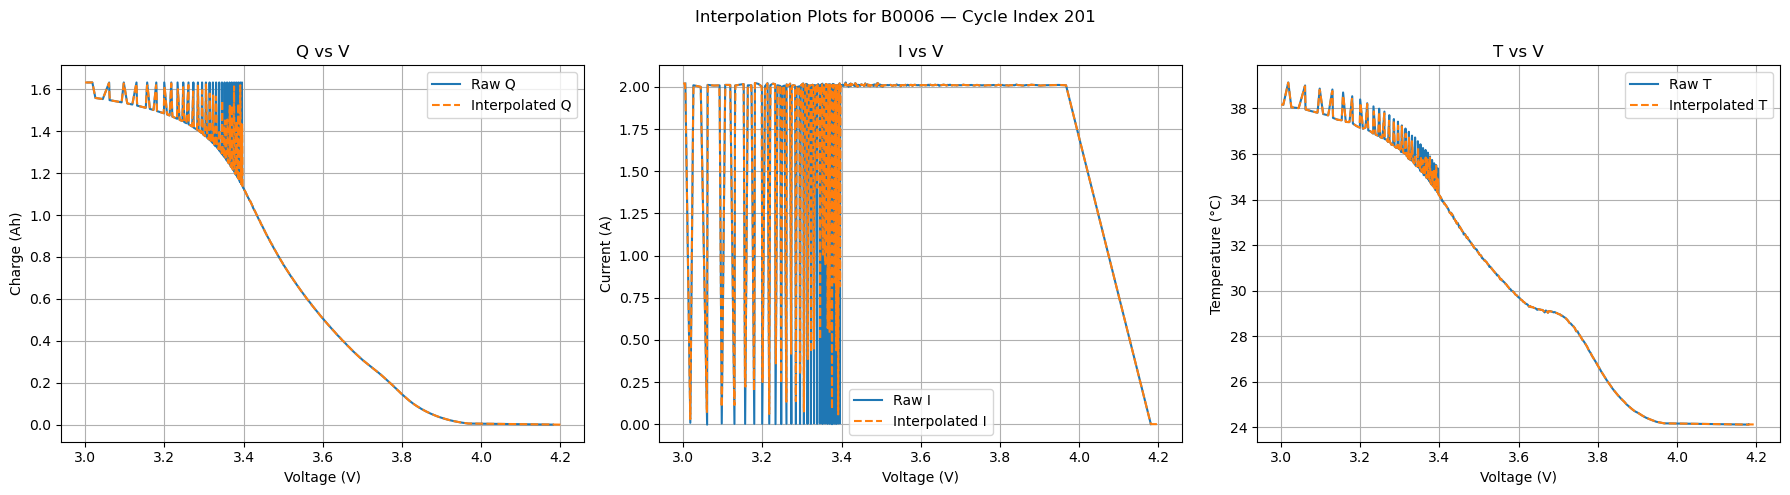

In [6]:
builder.plot_qit_from_dataframe(df_nasa, cell_id="B0006", cycle_index=201)

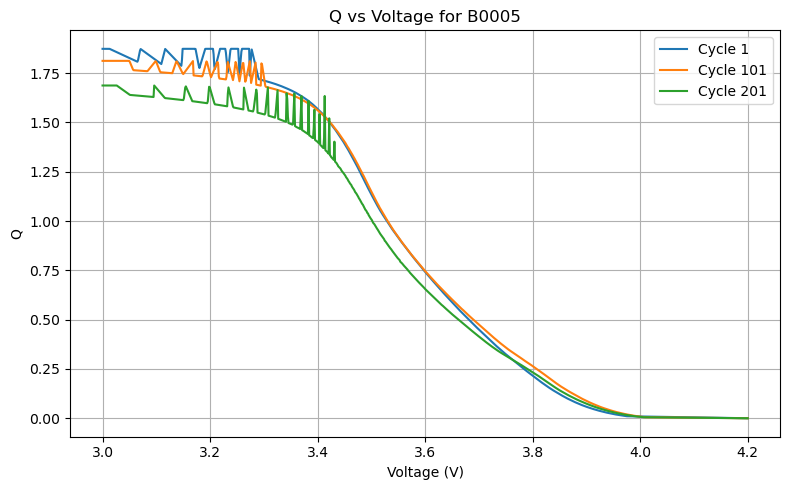

In [7]:
builder.plot_multiple_cycles(df_nasa, cell_id="B0005", cycle_idx=[1, 101, 201], signal='q') # 'q' or 'i' or 't'

In [8]:
builder.plot_signals_and_derivatives_vs_time(df_nasa, cell_id="B0027", cycle_index=0)


Entry not found.


In [9]:
builder.plot_signals_and_derivatives_plotly(df_nasa, "B0027", 73)

In [10]:
df_nasa.to_csv("../Datasets/nasa_Interp_flat.csv", index=False)

In [11]:
df_nasa.to_pickle("../Datasets/nasa_Interp_flat.pkl")

In [12]:
audit_all_df_nasa = builder.audit_duplicate_removal_safety(pd.read_pickle("../Datasets/nasa_Interp_flat.pkl"), signal="voltage_raw", threshold=1e-5)
audit_all_df_nasa['safe_to_remove'].unique()

array([ True])